In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
THRESHOLD = 3.0
HISTOGRAM_THRESHOLD = 2.0

ANTIMERES = ['13-23', '14-24', '15-25', '16-26', '17-27',\
            '33-43', '34-44', '35-45', '36-46', '37-47']

MEASURE_TYPES = ['.cc', '.ctd', '.ct', '.gm']
df = pd.read_csv("cases.csv",index_col="Patient ID", skiprows=1)

# removing all cases with maximum predicted expansion below threshold
df = df[(df['Max(4,5,6) Mx Exp'] >= THRESHOLD) & (df['Include?'] == 'Y')]

In [3]:
def percentAccuracy(row, antimere, measure_type):
    '''Given a row with "xx-xxi", "xx-xxp", "xx-xxf" columns for
    initial, predicted, and final arch widths across antimeres
    "xx-xx" (e.g. 13-23), returns the % of predicted expansion achieved.
    
    Antimere must be in the form '1x-2x' or '3x-4x'
    
    These antimeres also have suffix measure_type that is
    .cc, .ctd, .ct, .gm depending on how they were measured
    (ClinCheck archwidth, centroid, cusp tip, gingival margin)
    
    Note that is technically NOT accuracy, since
    if f > p, then 'accuracy' will be >100%.
    It is better described as % of predicted expansion achieved.

    Returns None if predicted expansion = 0'''
    
    predWidth = row[antimere+'p'+measure_type]
    achWidth = row[antimere+'f'+measure_type]
    initWidth = row[antimere+'i'+measure_type]
    
    predExp =  predWidth - initWidth
    achExp =  achWidth - initWidth
    
    if 0 in [predExp, predWidth, achWidth, initWidth]:
        return None
    return 100*achExp/predExp

def predictedExp(row, antimere, measure_type):
    '''Returns predicted expansion for a given row, antimere, measure type'''
    predWidth = row[antimere+'p'+measure_type]
    initWidth = row[antimere+'i'+measure_type]
    if predWidth == 0 or initWidth == 0:
        return None
    # assert(predWidth != initWidth)
    return predWidth - initWidth

def achievedExp(row, antimere, measure_type):
    '''Returns predicted expansion for a given row, antimere, measure type'''
    achWidth = row[antimere+'f'+measure_type]
    initWidth = row[antimere+'i'+measure_type]
    if initWidth == 0 or achWidth == 0:
        return None
    # assert(predWidth != initWidth)
    return achWidth - initWidth

def getColumn(df, column_name, antimere, threshold, measure_type, aligner_material):
    df = df[df['Aligner Material'] == aligner_material]
    if type(threshold) == bool and threshold == False:
        return df[column_name]
    return df[df['pΔ%s%s' % (antimere, measure_type)] > threshold][column_name]

# def percentAccuracy(row, antimere, measure_type):
#     pError = percentError(row, antimere, measure_type)
#     if pError == None:
#         return pError
#     return 100-pError

In [4]:
for antimere in ANTIMERES:
    # Ensure all xx-xxipf columns are type float
    for measure_type in MEASURE_TYPES:
        if measure_type == '.cc' and '7' in antimere:
            continue

        df[antimere+'i'+measure_type].astype(float)
        df[antimere+'p'+measure_type].astype(float)
        df[antimere+'f'+measure_type].astype(float)

        # Create 'xx-xx %acc' column for each antimere
        full_antimere = antimere + measure_type
        df['%s %%acc' % full_antimere] = df.apply(lambda row: percentAccuracy(row, antimere, measure_type), axis=1)

        # Create 'pΔxx-xx.xx' & 'aΔxx-xx.xx' column for each antimere/measure type
        df['pΔ%s' % full_antimere] = df.apply(lambda row: predictedExp(row, antimere, measure_type), axis=1)
        df['aΔ%s' % full_antimere] = df.apply(lambda row: achievedExp(row, antimere, measure_type), axis=1)


In [5]:
# Plot histogram of %accuracy for each antimere        

def plotHistograms(df, aligner_material, measure_type):
    '''Plots histogram & outputs .PDF for a given
    aligner_material (EX30 or LD30) and
    measure_type (.cc, .ctd, .ct, or .gm)
    
    df should be filtered for cases passing threshold
    ONLY (i.e. df)
    '''
    
    pp = PdfPages('output/%s%s-histograms.pdf' % (aligner_material, measure_type))

    for antimere in ANTIMERES:
        if measure_type == '.cc' and '7' in antimere:
            continue
        full_antimere = antimere+measure_type

        f = plt.figure()

        plt.subplot(1, 2, 1)

        col1 = getColumn(df, '%s %%acc' % full_antimere, antimere, False, measure_type, aligner_material).dropna()            
        col1.hist(bins=10)
        plt.title('%s %s\n%%acc\nmean=%s\nn=%s' % (aligner_material, full_antimere, col1.mean(), len(col1)))

        plt.xlabel('% Accuracy')
        plt.ylabel('Frequency')

        # Plot histogram of %accuracy > THRESHOLD for each antimere
        plt.subplot(1, 2, 2)

        col2 = getColumn(df, '%s %%acc' % full_antimere, antimere, HISTOGRAM_THRESHOLD, measure_type, aligner_material).dropna()            
        col2.hist(bins=10)
        plt.title('%s %s\n%%acc when predExp > %s mm\nmean=%s\nn=%s' % (aligner_material, full_antimere, HISTOGRAM_THRESHOLD, col2.mean(), len(col2)))

        plt.xlabel('% Accuracy')
        plt.ylabel('Frequency')

        pp.savefig(f, bbox_inches="tight")
        plt.show()
    pp.close()

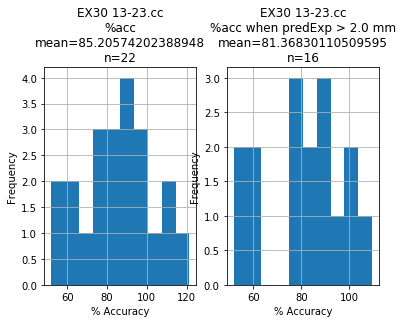

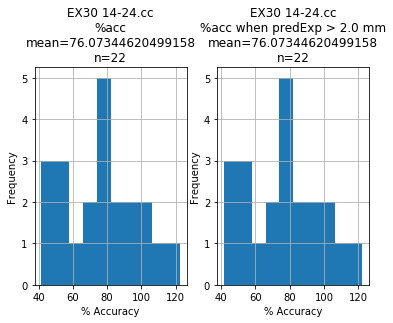

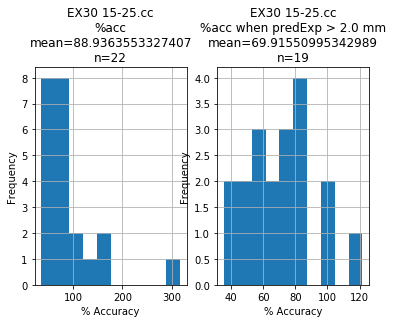

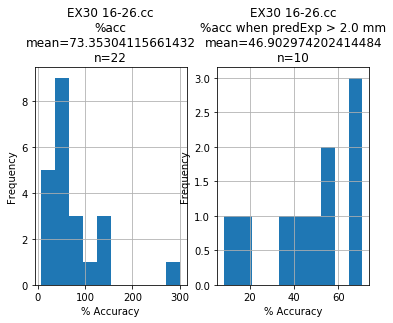

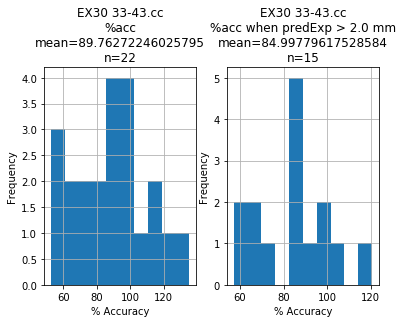

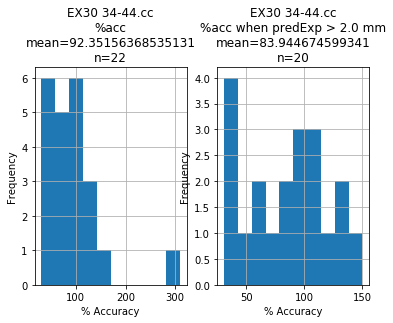

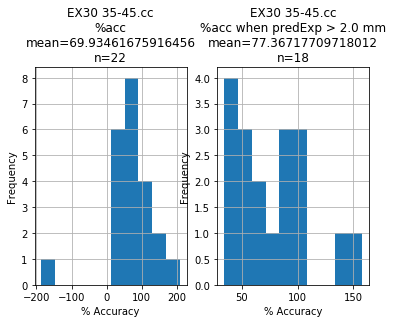

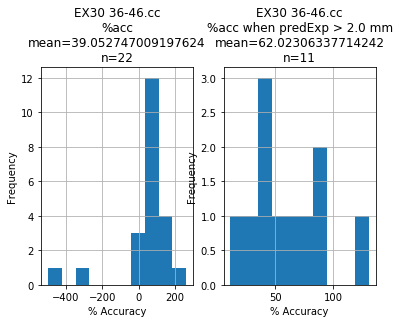

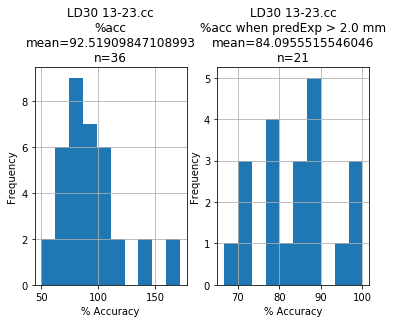

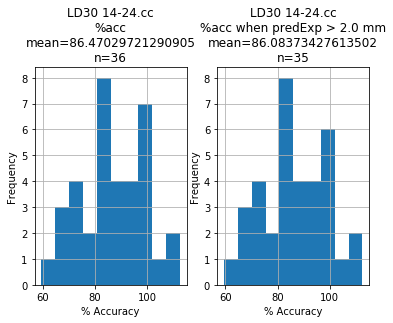

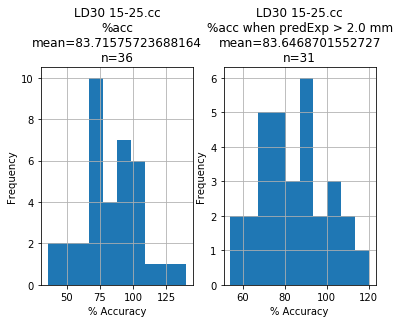

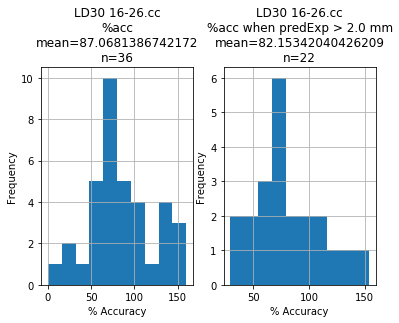

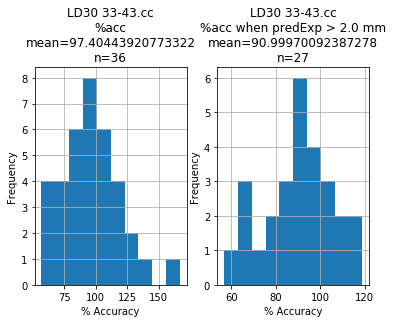

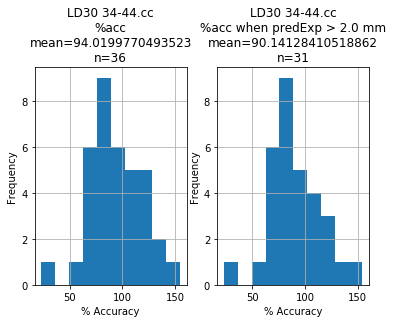

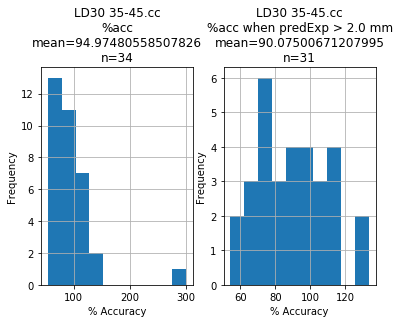

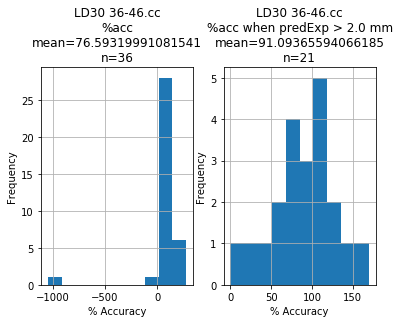

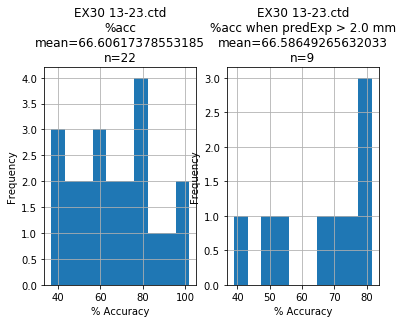

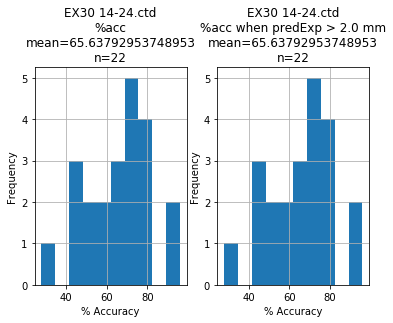

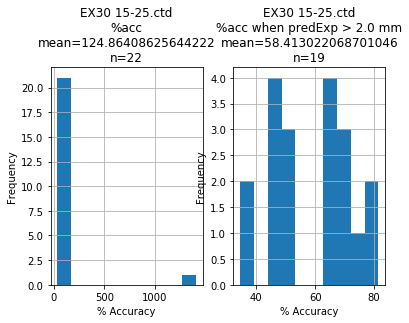

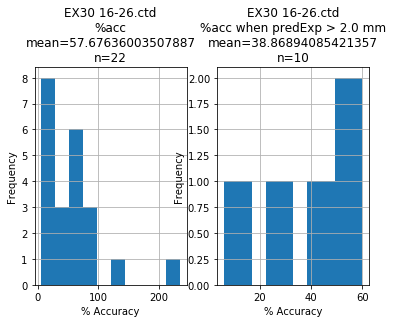

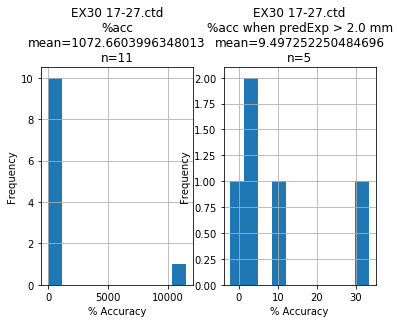

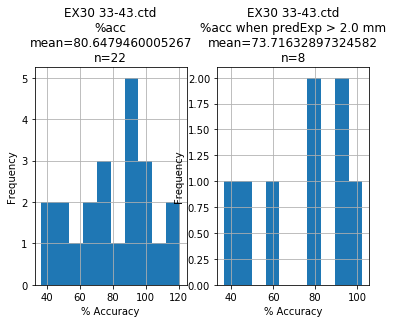

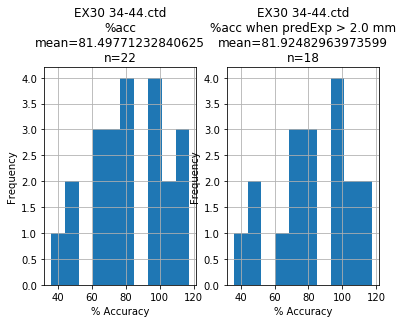

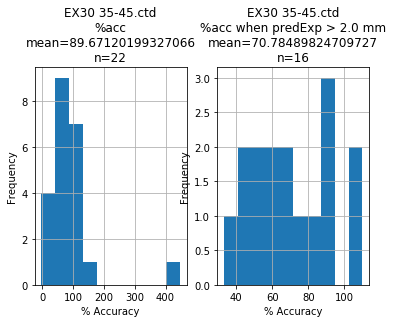

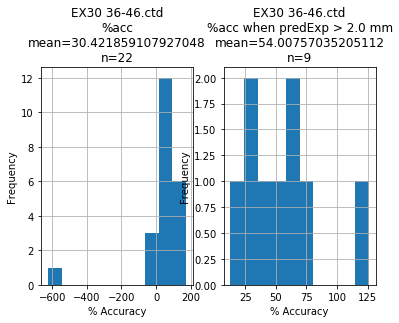

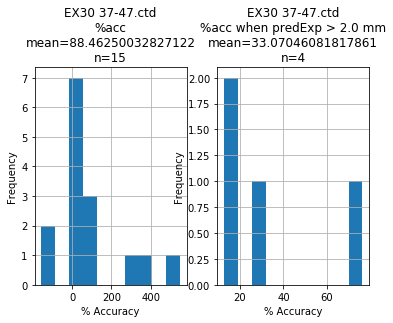

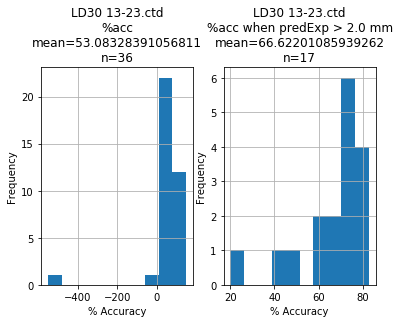

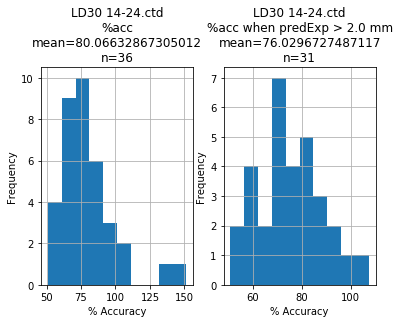

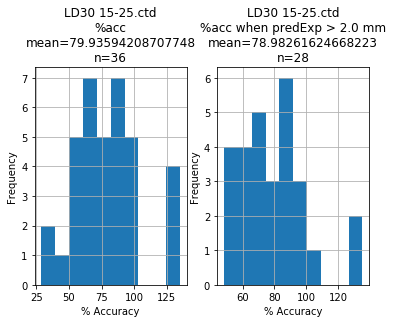

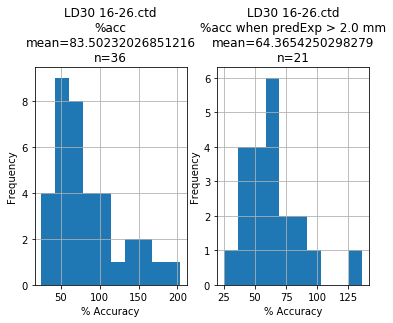

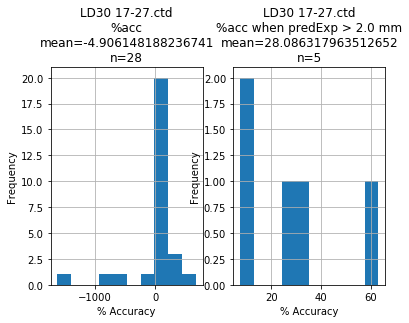

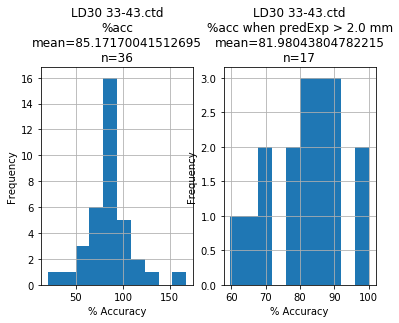

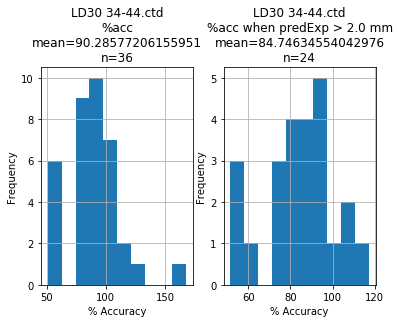

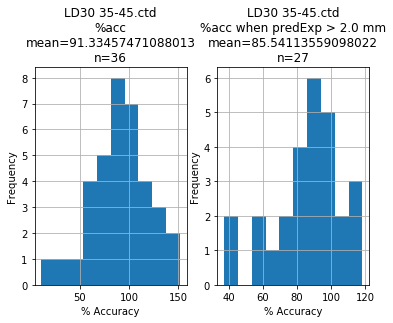

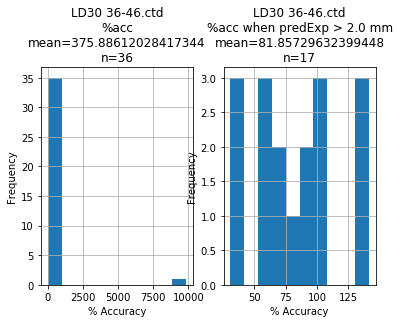

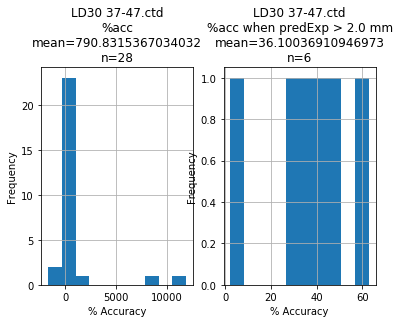

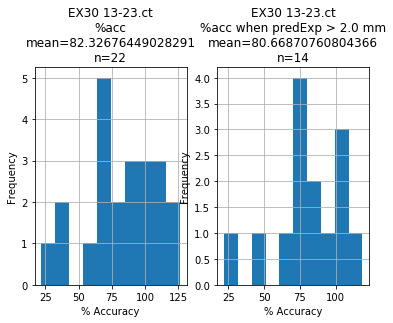

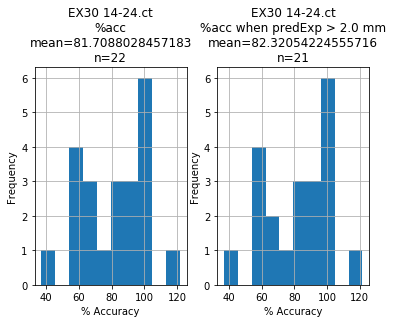

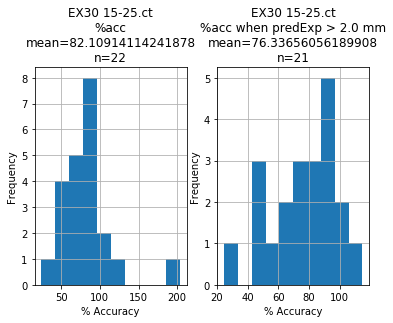

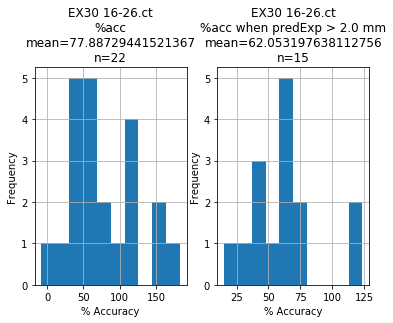

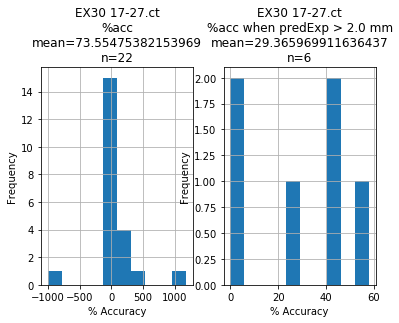

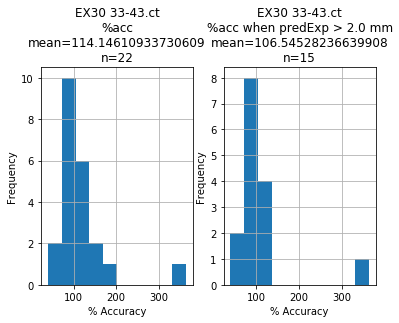

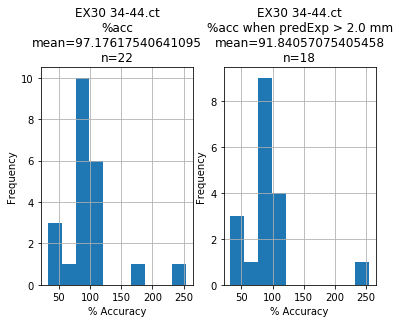

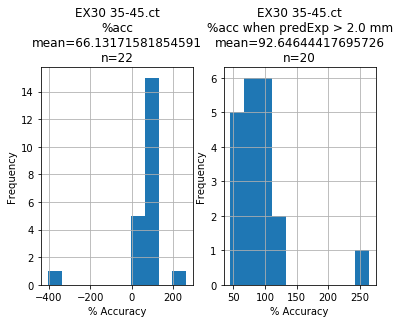

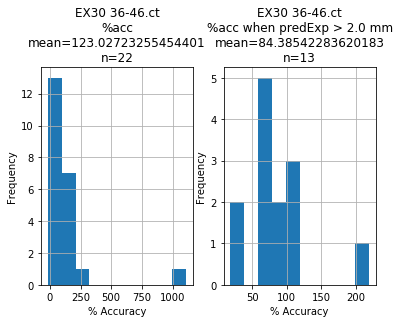

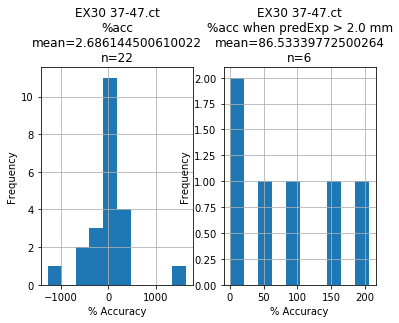

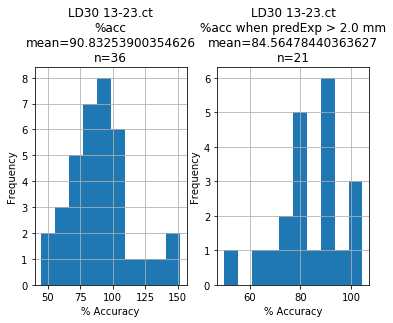

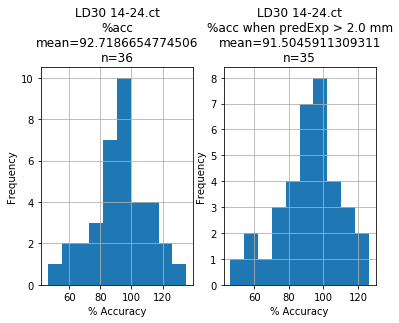

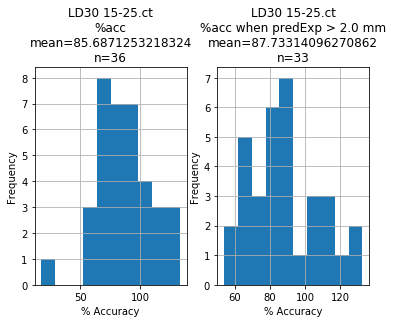

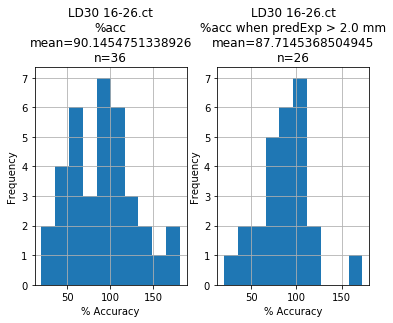

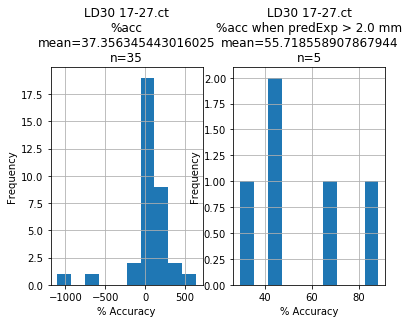

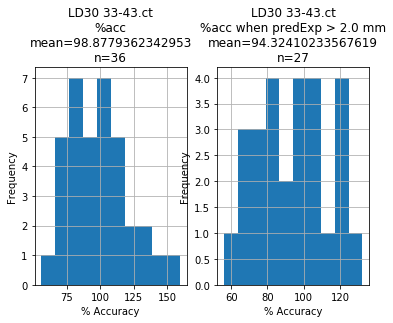

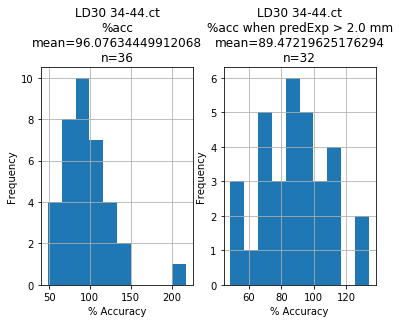

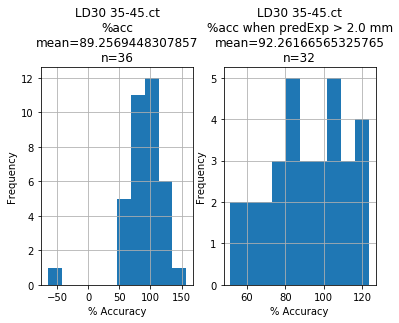

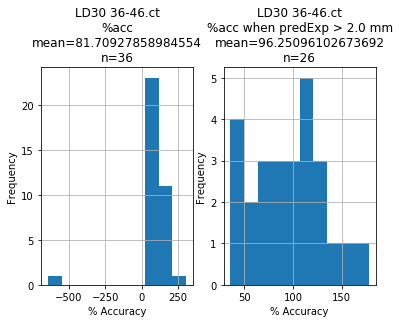

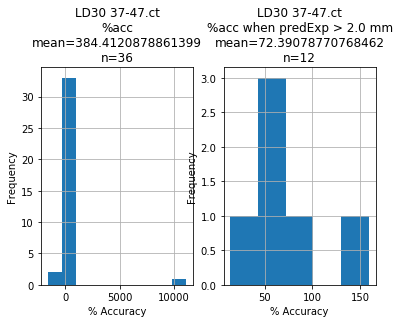

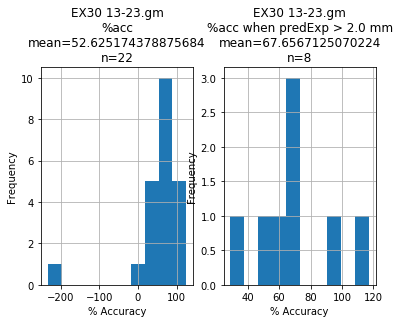

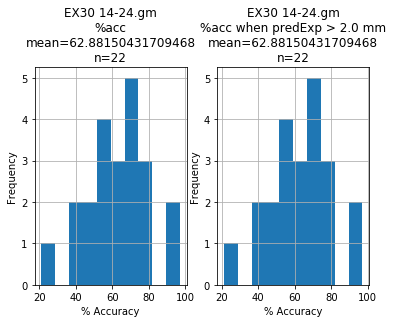

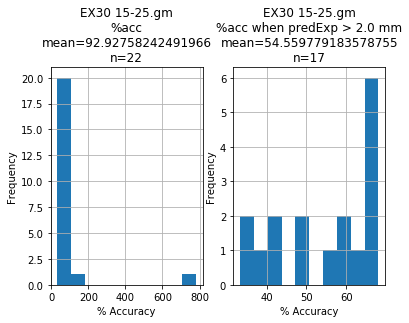

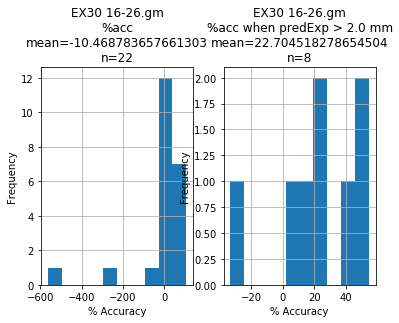

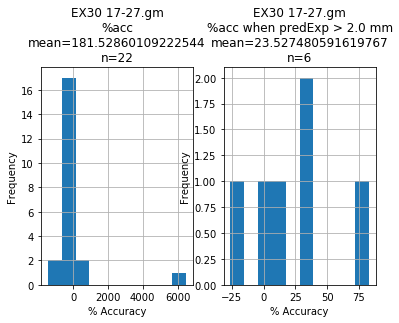

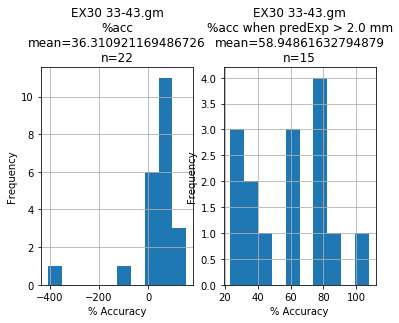

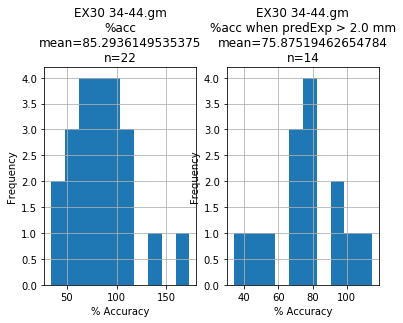

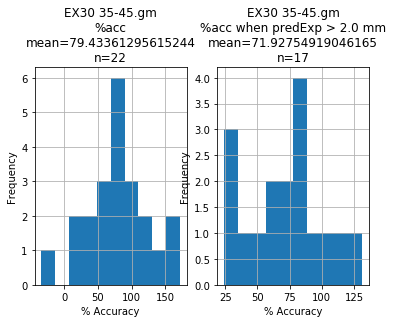

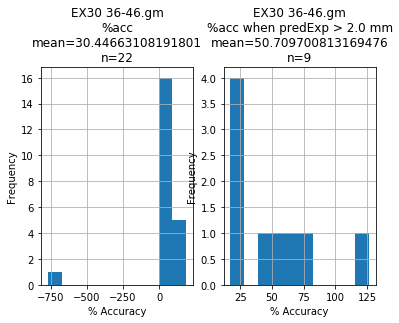

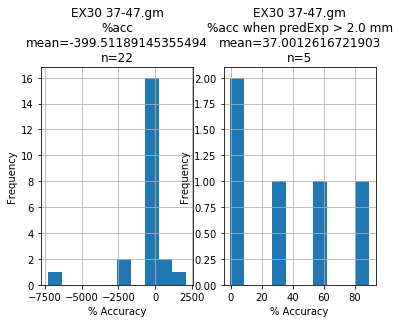

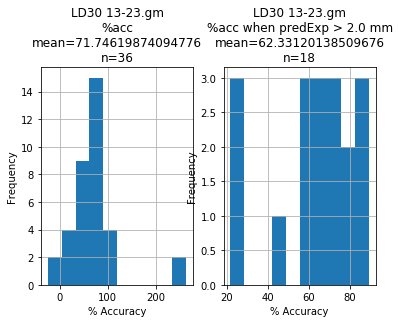

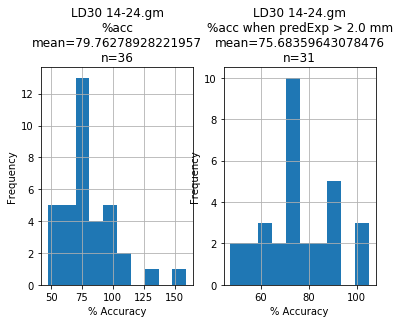

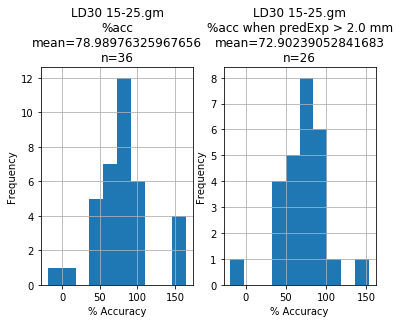

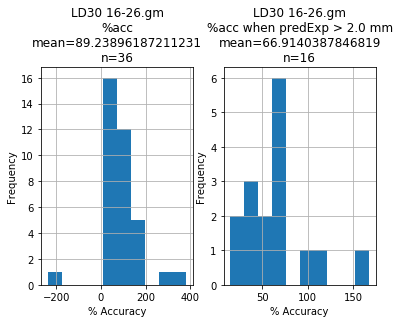

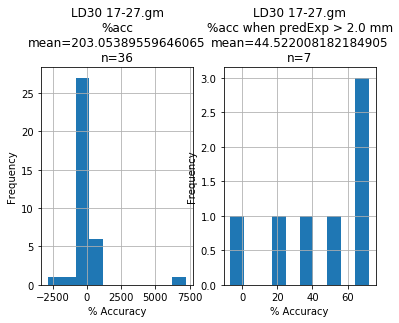

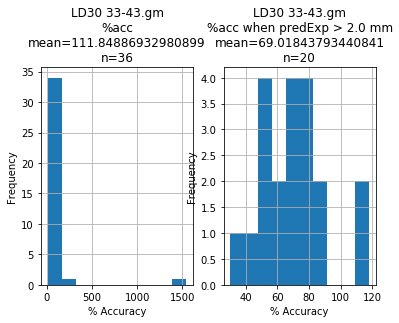

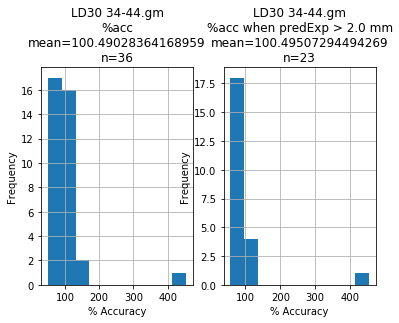

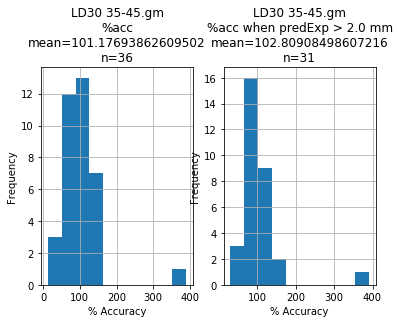

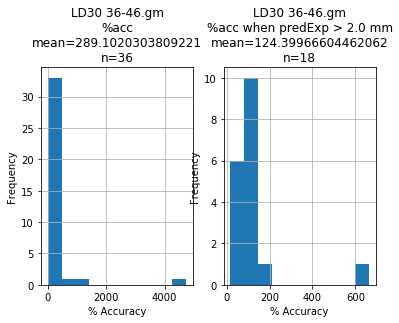

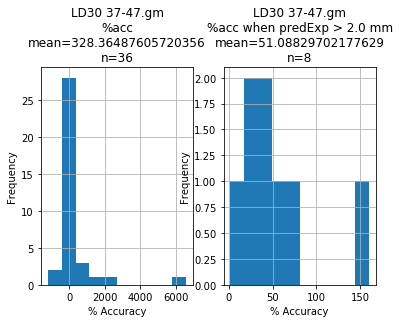

In [6]:
LD30 = df[df['Aligner Material'] == 'LD30']
EX30 = df[df['Aligner Material'] == 'EX30']

for measure_type in MEASURE_TYPES:
    plotHistograms(df, 'EX30', measure_type)
    plotHistograms(df, 'LD30', measure_type)

In [7]:
def printMeanAccuracies(df):

    print(LD30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].mean())
    print(LD30[['13-23.ctd %acc', '14-24.ctd %acc', '15-25.ctd %acc', '16-26.ctd %acc']].mean())
    print(EX30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].mean())
    print(EX30[['13-23.ctd %acc', '14-24.ctd %acc', '15-25.ctd %acc', '16-26.ctd %acc']].mean())

printMeanAccuracies(df)

13-23.cc %acc    92.519098
14-24.cc %acc    86.470297
15-25.cc %acc    83.715757
16-26.cc %acc    87.068139
dtype: float64
13-23.ctd %acc    53.083284
14-24.ctd %acc    80.066329
15-25.ctd %acc    79.935942
16-26.ctd %acc    83.502320
dtype: float64
13-23.cc %acc    85.205742
14-24.cc %acc    76.073446
15-25.cc %acc    88.936355
16-26.cc %acc    73.353041
dtype: float64
13-23.ctd %acc     66.606174
14-24.ctd %acc     65.637930
15-25.ctd %acc    124.864086
16-26.ctd %acc     57.676360
dtype: float64


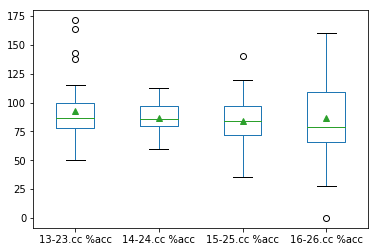

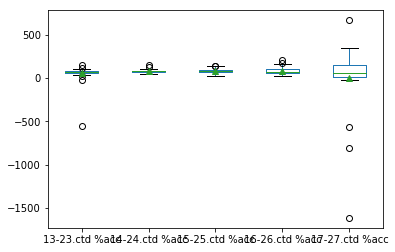

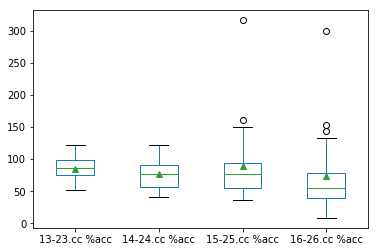

In [8]:
def boxPlots():
    LD30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].plot.box(showmeans=True)
    LD30[['13-23.ctd %acc', '14-24.ctd %acc', '15-25.ctd %acc', '16-26.ctd %acc', '17-27.ctd %acc']].plot.box(showmeans=True)
    EX30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].plot.box(showmeans=True)
    # EX30[['13-23.cc %acc', '14-24.cc %acc', '15-25.cc %acc', '16-26.cc %acc']].plot.hist(alpha=0.5, stacked=True)
boxPlots()

In [9]:
# STATS


def printStats(col1, col2, mat1, mat2, measure_type, threshold, stats_fn):
    '''Prints statistical analysis comparing col1 (e.g. %acc) of mat1 (EX30
    or LD30) vs col2 of mat2,'''
print("Is the %%accuracy of EX30 significantly different to LD30, when\
 requested expansion > %s mm?\n" % HISTOGRAM_THRESHOLD)
for i, j in zip([1, 3], [2, 4]):
    for toothNum in range(3, 8):
        for measure_type in ['.cc']: ###
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s' % (i, toothNum, j, toothNum, measure_type)
            
            col1 = getColumn(df, '%s %%acc' % full_antimere, antimere, HISTOGRAM_THRESHOLD, measure_type, 'LD30')            
            col2 = getColumn(df, '%s %%acc' % full_antimere, antimere, HISTOGRAM_THRESHOLD, measure_type, 'EX30')
            stat, p = stats.ttest_ind(col1, col2, nan_policy='omit')
            
            print('---%s---' % full_antimere)
            print('LD30: mean=%s\tstd=%s\tn=%s' % (col1.mean(), col1.std(), col1.count()))
            print('EX30: mean=%s\tstd=%s\tn=%s' % (col2.mean(), col2.std(), col2.count()))
            print('p=%s' % p)
            if p < 0.05:
                print('*** ***')
            else:
                print('--- ---')

print("Is the %accuracy of EX30 significantly different to LD30, \
for any level of requested expansion?\n")
for i, j in zip([1, 3], [2, 4]):
    for toothNum in range(3, 8):
        for measure_type in ['.cc']: ###
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s' % (i, toothNum, j, toothNum, measure_type)

            col1 = getColumn(df, '%s %%acc' % full_antimere, antimere, False, measure_type, 'LD30')
            col2 = getColumn(df, '%s %%acc' % full_antimere, antimere, False, measure_type, 'EX30')
            stat, p = stats.ttest_ind(col1, col2, nan_policy='omit')
            
            print('---%s---' % full_antimere)
            print('LD30: mean=%s\tstd=%s\tn=%s' % (col1.mean(), col1.std(), col1.count()))
            print('EX30: mean=%s\tstd=%s\tn=%s' % (col2.mean(), col2.std(), col2.count()))
            print('p=%s' % p)
            if p < 0.05:
                print('*** ***')
            else:
                print('--- ---')

print("Is the actual expansion of LD30 significantly different \
to its predicted expansion, for cases where predicted expansion >%smm?\n"\
     % HISTOGRAM_THRESHOLD)
for i, j in zip([1, 3], [2, 4]):
    for toothNum in range(3, 8):
        for measure_type in ['.cc']: ###
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)

            col1 = getColumn(df, '%sf%s' % (antimere, measure_type), antimere, HISTOGRAM_THRESHOLD, measure_type, 'LD30')
            col2 = getColumn(df, '%sp%s' % (antimere, measure_type), antimere, HISTOGRAM_THRESHOLD, measure_type, 'LD30')
            stat, p = stats.ttest_rel(col1, col2, nan_policy='omit')
            
            print('---%s---' % full_antimere)
            print('LD30: mean=%s\tstd=%s\tn=%s' % (col1.mean(), col1.std(), col1.count()))
            print('EX30: mean=%s\tstd=%s\tn=%s' % (col2.mean(), col2.std(), col2.count()))
            print('p=%s' % p)
            if p < 0.05:
                print('*** ***')
            else:
                print('--- ---')

print("Is the actual expansion of EX30 significantly different \
to its predicted expansion, for cases where predicted expansion >%smm?\n"\
     % HISTOGRAM_THRESHOLD)
for i, j in zip([1, 3], [2, 4]):
    for toothNum in range(3, 8):
        for measure_type in ['.cc']: ###
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)

            col1 = getColumn(df, '%sf%s' % (antimere, measure_type), antimere, HISTOGRAM_THRESHOLD, measure_type, 'LD30')
            col2 = getColumn(df, '%sp%s' % (antimere, measure_type), antimere, HISTOGRAM_THRESHOLD, measure_type, 'LD30')
            stat, p = stats.ttest_rel(col1, col2, nan_policy='omit')
            
            print('---%s---' % full_antimere)
            print('LD30: mean=%s\tstd=%s\tn=%s' % (col1.mean(), col1.std(), col1.count()))
            print('EX30: mean=%s\tstd=%s\tn=%s' % (col2.mean(), col2.std(), col2.count()))
            print('p=%s' % p)
            if p < 0.05:
                print('*** ***')
            else:
                print('--- ---')

Is the %accuracy of EX30 significantly different to LD30, when requested expansion > 2.0 mm?

---13-23.cc---
LD30: mean=84.0955515546046	std=9.750861345509202	n=21
EX30: mean=81.36830110509595	std=17.490359152394745	n=16
p=0.550050261211
--- ---
---14-24.cc---
LD30: mean=86.08373427613502	std=12.477336386084032	n=35
EX30: mean=76.07344620499158	std=23.154923644943175	n=22
p=0.038459808298
*** ***
---15-25.cc---
LD30: mean=83.6468701552727	std=16.331908031557376	n=31
EX30: mean=69.91550995342989	std=22.257543789316546	n=19
p=0.0154885691925
*** ***
---16-26.cc---
LD30: mean=82.15342040426209	std=29.940948111123173	n=22
EX30: mean=46.902974202414484	std=20.67394109664038	n=10
p=0.0021248032805
*** ***
---33-43.cc---
LD30: mean=90.99970092387278	std=15.95563470448671	n=27
EX30: mean=84.99779617528584	std=17.475573275382168	n=15
p=0.265492591519
--- ---
---34-44.cc---
LD30: mean=90.14128410518862	std=25.667500608097154	n=31
EX30: mean=83.944674599341	std=34.46711146289469	n=20
p=0.46582314

In [10]:
for antimere in ANTIMERES:
    for measure_type in ['.cc']: ###
        if measure_type == '.cc' and '7' in antimere:
            continue
        stat, p = stats.ttest_rel(LD30['%sf%s'%(antimere,measure_type)], LD30['%sp%s'%(antimere,measure_type)],nan_policy='omit')
        print('LD30', antimere, p)

LD30 13-23 0.00597607487109
LD30 14-24 5.75073337538e-07
LD30 15-25 3.20637143392e-06
LD30 16-26 0.00775608135966
LD30 33-43 0.0200875313639
LD30 34-44 0.0773204265074
LD30 35-45 0.00218411391909
LD30 36-46 0.416287802408


In [11]:
def getSubDf(df, measure_type, threshold, aligner_material):
    '''Returns a df with specified measure_type, aligner_material, and
    above predicted expansion threshold only'''
    cols = []
    for antimere in ANTIMERES:
        if measure_type == '.cc' and '7' in antimere:
            continue
        col = getColumn(df, '%s%s %%acc' % (antimere, measure_type), antimere, threshold, measure_type, aligner_material)    
        cols.append(col)
    return pd.concat(cols, axis=1)

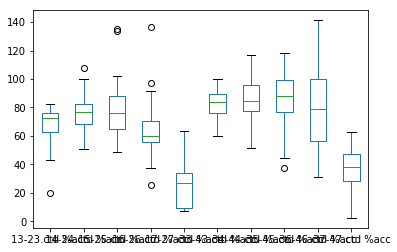

In [12]:
getSubDf(df, '.ctd', HISTOGRAM_THRESHOLD, 'LD30').plot.box()

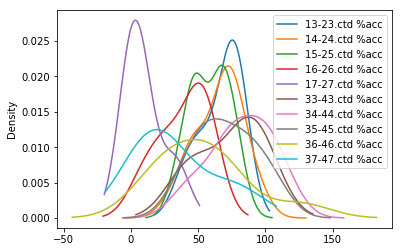

In [13]:
getSubDf(df, '.ctd', HISTOGRAM_THRESHOLD, 'EX30').plot.kde()

In [14]:
# getSubDf(df, '.ctd', 2, 'LD30').mean()
# getSubDf(df, '.ctd', 2, 'LD30').std()

In [15]:
#### df.to_csv('cases-to-dr-lavrin.csv')

In [26]:
getColumn(df, '33-43.ct %acc', '33-43', 2, '.ct', 'EX30')

Patient ID
1645196     51.187335
1654114     87.139108
1809618    113.220339
1856705     90.023753
1955743    363.934426
1974079     84.722222
1982901    106.726457
2012257     84.375000
2103852     83.274021
2232325     81.203008
2252538     39.754098
2286253     82.142857
2361557    128.627451
2579782    113.983051
2670212     87.866109
Name: 33-43.ct %acc, dtype: float64

In [22]:
df.head()

,Treatment Start Date,Aligner Material,Patient Name,Treatment Type,Patient Age,Include?,"Max(4,5,6) Mx Exp","Avg(4,5,6) Exp",13-23i.cc,13-23p.cc,...,aΔ36-46.gm,37-47.ctd %acc,pΔ37-47.ctd,aΔ37-47.ctd,37-47.ct %acc,pΔ37-47.ct,aΔ37-47.ct,37-47.gm %acc,pΔ37-47.gm,aΔ37-47.gm
Patient ID,,,,,,,,,,,,,,,,,,,,,
1645196,16/2/10,EX30,"M, Lauren",FULL,29,Y,3.6,2.833333333,30.1,34.4,...,0.72,NaN,0.000000,-0.498632,-346.153846,0.13,-0.45,-500.000000,0.02,-0.10
1654114,25/2/10,EX30,"S, Michelle",FULL,34,Y,4.4,3.333333333,32.4,35.7,...,1.06,373.177317,0.274662,1.024974,275.000000,1.04,2.86,-7284.615385,0.13,-9.47
1776637,12/7/10,EX30,"M, Keysha",FULL,33,Y,4.5,3,31.4,33.5,...,1.50,547.954530,0.132185,0.724315,1645.454545,0.11,1.81,427.027027,0.37,1.58
1809618,23/8/10,EX30,"V, Deenal",FULL,25,Y,3.5,2.466666667,30.2,32.7,...,0.98,77.163831,0.390525,0.301344,255.555556,0.18,0.46,-30.303030,0.33,-0.10
1812712,25/8/10,EX30,"T, Phillip",FULL,27,Y,3.2,2.633333333,33.7,36.6,...,0.61,18.074618,1.971684,0.356374,73.913043,1.84,1.36,-47.286822,1.29,-0.61
